In [8]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from src.ParticleCloud import EdgeConvolutionLayer, ChannelWiseGlobalAvaragePooling
from src.Preprocessing import JetProcessingParticleCloud
from src.Particle import ParticleType
from sklearn.model_selection import train_test_split

In [2]:
data_gluon = pd.read_csv('../../Data/g_jets.csv', header=None, sep=' ')[:500]
data_quark = pd.read_csv('../../Data/q_jets.csv', header=None, sep=' ')[:500]
data_top = pd.read_csv('../../Data/t_jets.csv', header=None, sep=' ')[:500]

In [3]:
# joinning data frames
all_jets = pd.concat([data_top, data_quark.loc[:int(len(data_quark)/2), :], data_gluon.loc[:int(len(data_quark)/2), :]], axis=0)
all_jets.reset_index(drop=True, inplace=True)
# defining the dictionary with the order of jets in the full data frame
jets_order = {
    ParticleType.Top: (0, len(data_top) - 1), 
    ParticleType.LightQuark: (len(data_top), len(all_jets) - 1),
}

In [4]:
jet_preprocessing = JetProcessingParticleCloud()
X = jet_preprocessing.transform(X=all_jets.to_numpy(), y=jets_order)
y = jet_preprocessing.jet_labels

In [5]:
# Dividing the data into trainning, validation, and test
# diving the set into trainning, validation, and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

print(f"Size of the Training set: {len(X_train)}")
print(f"Size of the Validation set: {len(X_val)}")
print(f"Size of the Test set: {len(X_test)}")

Size of the Training set: 723
Size of the Validation set: 128
Size of the Test set: 151


In [6]:
# first we need the MLP
# just including one layer
mlp_jets = keras.Sequential([
    keras.layers.InputLayer(shape=[6]),
    keras.layers.Dense(4, activation='relu'),
    keras.layers.Dense(4, activation='relu'),
    keras.layers.Dense(3, activation='relu')
])

# defining the EdgeConv layer
edge_convolution_layer = EdgeConvolutionLayer(mlp=mlp_jets, k_neighbors=7, final_index_coord=2, max_number_particles=30)

# Create the model
input_data = keras.layers.Input(shape=(30, 3))
edge_outputs = edge_convolution_layer(input_data)
jet_tag_model = keras.models.Model(inputs=input_data, outputs=edge_outputs)

jet_tag_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 30, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ edge_convolution_layer          │ (None, 30, 3)          │            63 │
│ (EdgeConvolutionLayer)          │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63 (252.00 B)

 Trainable params: 63 (252.00 B)

 Non-trainable params: 0 (0.00 B)

In [9]:
pooling = ChannelWiseGlobalAvaragePooling()

In [10]:
X_trans = edge_convolution_layer.call_on_sample(X[0])

In [11]:
X_trans

<tf.Tensor: shape=(30, 4), dtype=float32, numpy=
array([[0.        , 0.        , 0.        , 1.        ],
       [0.01648343, 0.        , 0.        , 1.        ],
       [0.0171672 , 0.        , 0.        , 1.        ],
       [0.02060091, 0.        , 0.        , 1.        ],
       [0.03057958, 0.        , 0.        , 1.        ],
       [0.04213989, 0.        , 0.        , 1.        ],
       [0.04007984, 0.        , 0.        , 1.        ],
       [0.03887902, 0.        , 0.        , 1.        ],
       [0.0426135 , 0.        , 0.        , 1.        ],
       [0.01885618, 0.        , 0.        , 1.        ],
       [0.04646039, 0.        , 0.        , 1.        ],
       [0.00140008, 0.        , 0.        , 1.        ],
       [0.04768058, 0.        , 0.        , 1.        ],
       [0.05582932, 0.        , 0.        , 1.        ],
       [0.04763347, 0.        , 0.        , 1.        ],
       [0.04483431, 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.     

In [17]:
Xs = edge_convolution_layer.call(X[:5])
pooling.call(Xs)

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0.0293101 , 0.        , 0.        ],
       [0.00919116, 0.        , 0.        ],
       [0.0106113 , 0.        , 0.        ],
       [0.02302834, 0.        , 0.        ],
       [0.02532112, 0.        , 0.        ]], dtype=float32)>

In [15]:
edge_convolution_layer.call(X[:5])

<tf.Tensor: shape=(5, 30, 4), dtype=float32, numpy=
array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
        [1.64834317e-02, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
        [1.71671975e-02, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
        [2.06009150e-02, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
        [3.05795800e-02, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
        [4.21398915e-02, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
        [4.00798433e-02, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
        [3.88790183e-02, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
        [4.26135026e-02, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
        [1.88561808e-02, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
        [4.64603901e-02, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
        [1.40008144e-03, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
        [4.76805829e-02, 0.00000000e+00, 0.00000000e+00, 1.0

In [10]:
jet_tag_model.compile(optimizer='adam', loss='crossentropy', metrics=['accuracy'])

In [11]:
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
jet_tag_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])   

Epoch 1/20
Instructions for updating:
Use fn_output_signature instead


OperatorNotAllowedInGraphError: Exception encountered when calling JetTagModel.call().

[1min user code:

    File "/var/folders/pk/v5d5f4l54wn_4q25t5hcq06w0000gn/T/ipykernel_12131/2501383171.py", line 9, in call  *
        return self.edge_convolution_layer(inputs)
    File "/opt/anaconda3/envs/PhD/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/Users/martines/Desktop/PhD/IA/IntroML/JetTagging/src/ParticleCloud.py", line 19, in call
        return tf.map_fn(self.call_on_sample, inputs, dtype=tf.float32)

    OperatorNotAllowedInGraphError: Exception encountered when calling EdgeConvolutionLayerSimple.call().
    
    [1min user code:
    
        File "/Users/martines/Desktop/PhD/IA/IntroML/JetTagging/src/ParticleCloud.py", line 36, in call_on_sample  *
            for neighbor_index, index_cloud in zip(self._find_neighbors(particle_index, coordinates),
    
        OperatorNotAllowedInGraphError: Iterating over a symbolic `tf.Tensor` is not allowed. You can attempt the following resolutions to the problem: If you are running in Graph mode, use Eager execution mode or decorate this function with @tf.function. If you are using AutoGraph, you can try decorating this function with @tf.function. If that does not work, then you may be using an unsupported feature or your source code may not be visible to AutoGraph. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/limitations.md#access-to-source-code for more information.
    [0m
    
    Arguments received by EdgeConvolutionLayerSimple.call():
      • inputs=tf.Tensor(shape=(None, 30, 3), dtype=float32)
[0m

Arguments received by JetTagModel.call():
  • inputs=tf.Tensor(shape=(None, 30, 3), dtype=float32)

In [9]:
# perfoming the prediction
y_train_pred = jet_tag_model.predict(X_train)
y_test_pred = jet_tag_model.predict(X_test)

7872/7872 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


In [10]:
from sklearn.metrics import recall_score, precision_score, confusion_matrix, precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

In [11]:
print("Trainnig set:")
print(f"Recall for Top tagging: {recall_score(y_train[:, 0], y_train_pred[:, 0] > 0.5):.2f}")
print(f"Precision for Top tagging: {precision_score(y_train[:, 0], y_train_pred[:, 0] > 0.5):.2f}")
print("Confusion Matrix")
print(confusion_matrix(y_train[:, 0], y_train_pred[:, 0] > 0.5, labels=[0, 1]))

Trainnig set:
Recall for Top tagging: 0.88
Precision for Top tagging: 0.83
Confusion Matrix
[[100471  22797]
 [ 14899 113714]]


In [12]:
print("Test set:")
print(f"Recall for Top tagging: {recall_score(y_test[:, 0], y_test_pred[:, 0] > 0.5):.2f}")
print(f"Precision for Top tagging: {precision_score(y_test[:, 0], y_test_pred[:, 0] > 0.5):.2f}")
print("Confusion Matrix")
print(confusion_matrix(y_test[:, 0], y_test_pred[:, 0] > 0.5, labels=[0, 1]))

Test set:
Recall for Top tagging: 0.88
Precision for Top tagging: 0.83
Confusion Matrix
[[20824  4900]
 [ 3085 23485]]


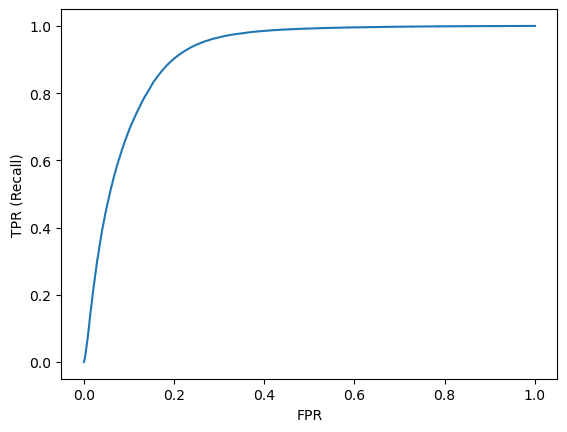

AUC: 0.91


In [13]:
# roc curve for top tagging 
fpr, tpr, thresholds = roc_curve(y_train[:, 0], y_train_pred[:, 0])
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR (Recall)')
plt.show()
print(f"AUC: {auc(fpr, tpr):.2f}")